In [101]:
import numpy as np
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib import cm

In [164]:
class SigmoidNeuron:
    def __init__(self, w_init, b_init, algo):
        self.w = w_init
        self.b = b_init
        self.w_h = []                 # history weights
        self.b_h = []                 # history biases
        self.e_h = []
        self.algo = algo
    def sigmoid(self, x, w = None, b = None):
        if w is None:
            w = self.w
        if b is None:
            b = self.b
        return 1.0 / (1.0 + np.exp(-(w * x + b)))
    def error(self, X, Y, w = None, b = None):
        if w is None:
            w = self.w
        if b is None:
            b = self.b
        err = 0
        for x, y in zip(X, Y):
            err += 0.5 * (self.sigmoid(x, w, b) - y) ** 2
        return err
    def grad_w(self, x, y, w = None, b = None):
        if w is None:
            w = self.w
        if b is None:
            b = self.b
        y_pred = self.sigmoid(x, w, b)
        return (y_pred - y) * (y_pred) * (1 - y_pred) * x
    def grad_b(self, x, y, w = None, b = None):
        if w is None:
            w = self.w
        if b is None:
            b = self.b
        y_pred = self.sigmoid(x, w, b)
        return (y_pred - y) * (y_pred) * (1 - y_pred) 
    def append_log(self):
        self.w_h.append(self.w)
        self.b_h.append(self.b)
        self.e_h.append(self.error(self.X, self.Y))
    def fit(self, X, Y, epochs = 100, lr = 0.01, beta = 0.9, gamma = 0.9, beta1 = 0.9,
            beta2 = 0.9, eps = 1e-8, batch_size = 100):
        self.w_h = []
        self.b_h = []
        self.e_h = []
        self.X = X
        self.Y = Y
        if self.algo == "GD":
            for i in range(epochs):
                dw, db = 0, 0
                for x,y in zip(X,Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                self.w -= lr * dw / X.shape[0]
                self.b -= lr * db / X.shape[0]
                self.append_log()
        elif self.algo == "MiniBatch":
            for i in range(epochs):
                dw, db = 0, 0
                points_seen = 0
                for x, y in zip(X,Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                    points_seen += 1
                    if(points_seen % batch_size == 0):
                        self.w -= lr * dw / batch_size
                        self.b -= lr * db / batch_size
                        self.append_log()
                        dw, db = 0, 0
        elif self.algo == "MomentumGD":
            v_w, v_b = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X,Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                v_w = gamma * v_w + lr * dw
                v_b = gamma * v_b + lr * db
                self.w -= v_w
                self.b -= v_b
                self.append_log()
        elif self.algo == "NAG":
            v_w, v_b = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X,Y):
                    w_temp = self.w - gamma * v_w
                    b_temp = self.b - gamma * v_b
                    dw += self.grad_w(x, y, w_temp, b_temp)
                    db += self.grad_b(x, y, w_temp, b_temp)
                v_w = gamma * v_w + lr * dw
                v_b = gamma * v_b + lr * db
                self.w = w_temp - lr * dw
                self.b = b_temp - lr * db
                self.append_log()
        elif self.algo == "AdaGrad":
            v_w, v_b = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y  in zip(X,Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                v_w += dw ** 2
                v_b += db ** 2
                self.w -= (lr/ (np.sqrt(v_w) + eps)) * dw
                self.b -= (lr/ (np.sqrt(v_b) + eps)) * db
                self.append_log()
        elif self.algo == "RMSProp":
            v_w, v_b = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                v_w = beta * v_w + (1 - beta) * (dw**2)
                v_b = beta * v_b + (1 - beta) * (db**2)
                self.w -= (lr/ (np.sqrt(v_w) + eps)) * dw
                self.b -= (lr/ (np.sqrt(v_b) + eps)) * db
                self.append_log()
        elif self.algo == "Adam":
            v_w, v_b = 0, 0
            m_w, m_b = 0, 0
            num_updates = 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                num_updates += 1
                m_w = beta1 * m_w + (1 - beta1) * dw
                m_b = beta1 * m_b + (1 - beta1) * db
                v_w = beta2 * v_w + (1 - beta2) * (dw**2)
                v_b = beta2 * v_b + (1 - beta2) * (db**2)
                m_w_c = m_w / (1 - np.power(beta1, num_updates))
                m_b_c = m_b / (1 - np.power(beta1, num_updates))
                v_w_c = v_w / (1 - np.power(beta2, num_updates))
                v_b_c = v_b / (1 - np.power(beta2, num_updates))
                self.w -= (lr/ (np.sqrt(v_w_c) + eps)) * m_w_c
                self.b -= (lr/ (np.sqrt(v_b_c) + eps)) * m_b_c
                self.append_log()

In [165]:
#X = np.asarray([0.5, 2.5])
#Y = np.asarray([0.2, 0.9])
#X = np.asarray([3.5, 0.35, 3.2])
#Y = np.asarray([0.49, 0.53, 0.52])
X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])
Y = np.asarray([0.5, 0.5, 0.5, 0.5, 0.1, 0.3])
algo = "Adam"
w_init = -6
b_init = 4
#w_init = 2.1
#b_init = 4.0
#w_init = -5
#b_init = 4
# GD fails in below case
#w_init = -4
#b_init = 0
epochs = 200
eps = 1e-8
batch_size = 2
#eta = 0.1
# RMSProp stuggles at larger learning rate
eta = 0.5
gamma = 0.9
w_min = -7
w_max = 5
b_min = -7
b_max = 5
animation_frames = 20
plot_3d = False
plot_2d = True

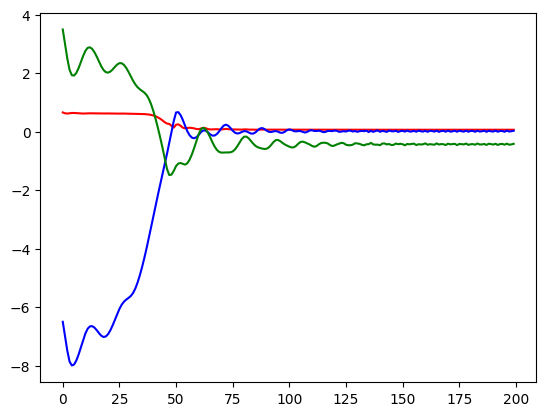

In [166]:
sn = SigmoidNeuron(w_init, b_init, algo)
sn.fit(X, Y, epochs = epochs, lr = eta , eps = eps, batch_size = batch_size)
plt.plot(sn.e_h,"r")
plt.plot(sn.w_h,"b")
plt.plot(sn.b_h,"g")
plt.show()

In [167]:
def plot_animate_3d(i):
    i = int(i *(epochs/animation_frames))
    line1.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
    line1.set_3d_properties(sn.e_h[:i+1])
    line2.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
    line2.set_3d_properties(np.zeros(i+1) - 1)
    title.set_text('Epoch {: d}, Error: {:.4f}'.format(i, sn.e_h[i]))
    return line1, line2, title

In [168]:
if plot_3d:
    W = np.linspace(w_min, w_max, 256)
    B = np.linspace(b_min, b_max, 256)
    WW, BB = np.meshgrid(W, B)
    Z = sn.error(X, Y, WW, BB)
    fig = plt.figure(dpi = 100)
    ax = fig.add_subplot(111, projection='3d') 
    surf = ax.plot_surface(WW, BB, Z, rstride = 3, cstride = 3, alpha = 0.9,
                           cmap = cm.coolwarm, linewidth = 0, antialiased = False)
    cont = ax.contourf(WW, BB, Z, 25, zdir = 'z', offset = -1, alpha = 0.9, cmap = cm.coolwarm)
    ax.set_xlabel("w")
    ax.set_xlim(w_min - 1, w_max + 1)
    ax.set_ylabel("b")
    ax.set_ylim(b_min - 1, b_max + 1)
    ax.set_zlabel("error")
    ax.set_zlim(-1, np.max(Z))
    ax.view_init(elev = 15, azim =-75)
    ax.set_box_aspect([1, 1, 0.5])
    title = ax.set_title("Epoch 0")

In [169]:
if plot_3d:
    i = 0
    line1, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], sn.e_h[:i+1], color = "red", marker = ".")
    line2, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], np.zeros(i+1) - 1, color = "red", marker = "." )
    anim = animation.FuncAnimation(fig, func = plot_animate_3d, frames = animation_frames)
    rc('animation', html = 'jshtml')
    anim

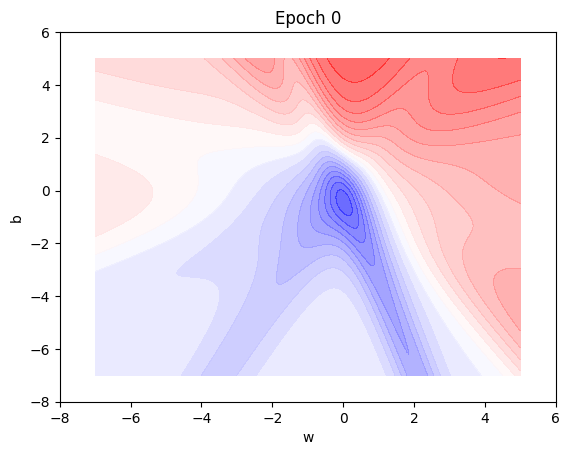

In [170]:
if plot_2d:
    W = np.linspace(w_min, w_max, 256)
    B = np.linspace(b_min, b_max, 256)
    WW, BB = np.meshgrid(W, B)
    fig = plt.figure(dpi = 100)
    ax = plt.subplot(111)
    Z = sn.error(X, Y,WW,BB)
    ax.set_xlabel("w")
    ax.set_ylabel("b")
    ax.set_xlim(w_min - 1, w_max + 1)
    ax.set_ylim(b_min - 1, b_max + 1)
    title = ax.set_title('Epoch 0')
    cset = plt.contourf(WW, BB, Z, 25, alpha = 0.6, cmap = cm.bwr)
    plt.show()

In [171]:
def plot_animate_2d(i):
    i = int(i *(epochs/animation_frames))
    line.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
    title.set_text('Epoch: {: d}, Error: {:.4f}'.format(i, sn.e_h[i]))
    return line, title    

In [172]:
if plot_2d:
    i = 0
    line, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], color = "black", marker = ".")
    anim = animation.FuncAnimation(fig, func = plot_animate_2d, frames = animation_frames)
    rc("animation", html = "jshtml")
    anim

In [173]:
if algo == "GD":
    print('algo = {}, eta = {}'.format(algo, eta))
elif algo == "NAG" or algo == "MomentumGD":
    print('algo = {}, eta = {}, gamma = {}'.format(algo, eta, gamma))
elif algo == "MiniBatch":
    print('algo = {}, eta = {}, batch size = {}'.format(algo, eta, batch_size))
elif algo == "AdaGrad" or algo == "RMSProp":
    print('algo = {}, eta = {}, eps = {}'.format(algo, eta, eps))

anim